In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm( vcenter=0)



import numpy as np
import sys
import lightning as L





sys.path.append('/users/local/c23lacro/script/NO_Sentinel/')
sys.path.append('/users/local/c23lacro/script/Koopman_DeepOperatorNet/')
from Lmodel import LKoopman
from light.Lmodel import NO_model

device = torch.device('cpu')

In [2]:
class KOOP(L.LightningModule):
    def __init__(self):
        super(KOOP, self).__init__()

CKPT_PATH_KOOP = '/users/local/c23lacro/script/Koopman_DeepOperatorNet/runs/27051013/1143/epoch=113-val_loss=0.00.ckpt'


In [3]:
##################################################################
#       Models
##################################################################

CKPT_PATH_KERNEL1 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_conv:FilterConvolution_kernel:[1, 1]_stride:1_skip:None_Res:False_activation:Linearlr:0.0001_batch:4/epoch=973-val_loss=0.00.ckpt'
CKPT_PATH_KERNEL3 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_conv:FilterConvolution_kernel:[3, 3]_stride:1_skip:None_Res:False_activation:Linearlr:0.0001_batch:4/epoch=973-val_loss=0.00.ckpt'
CKPT_PATH_FOU16 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_fourier_16_linear_Res:Truelr:0.0001batch:4/epoch=827-val_loss=0.00.ckpt'
CKPT_PATH_FOU32 = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_fourier_32_linear_Res:True_lr:0.0001_batch:4/epoch=987-eval_loss_total=0.03.ckpt'
CKPT_PATH_WAV = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/wavelet_res_linearSkip_lr1em4/epoch=993-val_loss=0.00.ckpt'
CKPT_PATH_KOOP = '/users/local/c23lacro/script/Koopman_DeepOperatorNet/runs/27051013/1143/epoch=113-val_loss=0.00.ckpt'

model_kernel1 = NO_model.load_from_checkpoint(CKPT_PATH_KERNEL1).to(device)
model_kernel3 = NO_model.load_from_checkpoint(CKPT_PATH_KERNEL3).to(device)
model_fou16 = NO_model.load_from_checkpoint(CKPT_PATH_FOU16).to(device)
model_fou32 = NO_model.load_from_checkpoint(CKPT_PATH_FOU32).to(device)
model_wav = NO_model.load_from_checkpoint(CKPT_PATH_WAV).to(device)
model_koop = LKoopman.load_from_checkpoint(CKPT_PATH_KOOP).to(device)

model_kernel1.eval()
model_kernel3.eval()
model_fou16.eval()
model_fou32.eval()
model_wav.eval()
model_koop.eval()

print('')


No skip connection
No skip connection



In [4]:
##################################################################
#       Data
##################################################################

path_data = '/users/local/c23lacro/data/Fontainebleau_interpolated_subdomain64.npy'
sentinel_data = np.load(path_data)

if np.max(sentinel_data) > 1:
    sentinel_data /= np.max(sentinel_data)


sentinel_data_diff = sentinel_data[1:,...] - sentinel_data[:-1,...]

sentinel_data = torch.tensor(np.append( sentinel_data[1:,...],sentinel_data_diff, axis=1)).float()

In [5]:
koop_image0 = sentinel_data[240].permute(1,2,0).reshape(-1,20)
koop_image0.shape

torch.Size([4096, 20])

In [6]:
##################################################################
#       Prediction
##################################################################

i_image0 = 240

image0 = sentinel_data[i_image0].unsqueeze(0).to(device)

print('model_kernel1')
out_kernel1,_ = model_kernel1(image0,sentinel_data.shape[0]-i_image0)
out_kernel1 = out_kernel1.squeeze(0)

print('model_kernel3')
out_kernel3,_ = model_kernel3(image0,sentinel_data.shape[0]-i_image0)
out_kernel3 = out_kernel3.squeeze(0)

print('model_fou16')
out_fou16,_ = model_fou16(image0,sentinel_data.shape[0]-i_image0)
out_fou16 = out_fou16.squeeze(0)

print('model_fou32')
out_fou32,_ = model_fou32(image0,sentinel_data.shape[0]-i_image0)
out_fou32 = out_fou32.squeeze(0)

print('model_wav')
out_wav,_ = model_wav(image0,sentinel_data.shape[0]-i_image0)
out_wav = out_wav.squeeze(0)

print('model_koop')
out_koop,_ = model_koop(koop_image0,sentinel_data.shape[0]-i_image0)
out_koop = out_koop.squeeze(0)
out_koop = out_koop.reshape(64,64,-1,20).permute(2,3,0,1)

model_kernel1
model_kernel3
model_fou16
model_fou32
model_wav
model_koop


In [7]:
def temporal_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2, dim=(1, 2, 3))).detach().cpu().numpy()
    return RMSE

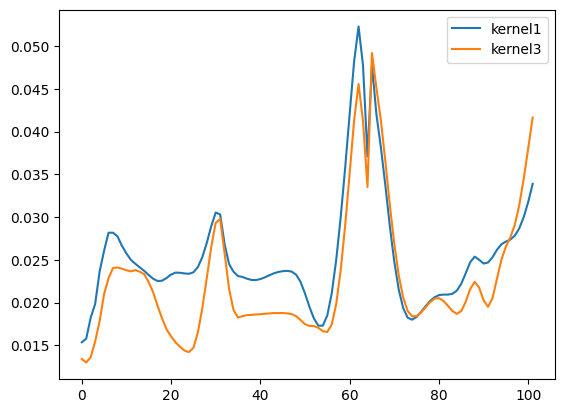

In [8]:
i = slice(0, 340)
plt.plot(temporal_RMSE(out_kernel1, sentinel_data[i_image0:])[i], label='kernel1')
plt.plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:])[i], label='kernel3')
# plt.plot(temporal_RMSE(out_fou16, sentinel_data[i_image0:])[i], label='fou16')
# plt.plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:])[i], label='fou32')
# plt.plot(temporal_RMSE(out_wav, sentinel_data[i_image0:])[i], label='wav')
plt.legend()

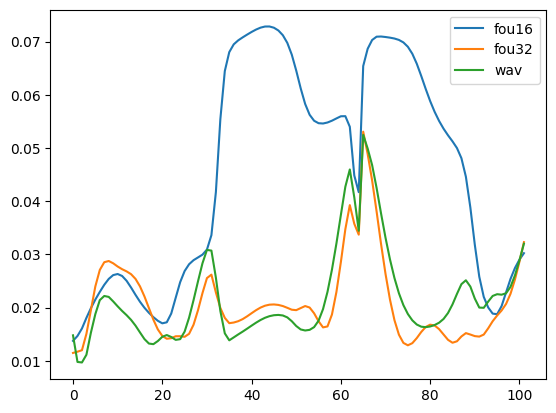

In [9]:
# i = slice(0, 160)
# plt.plot(temporal_RMSE(out_kernel1, sentinel_data[i_image0:])[i], label='kernel1')
# plt.plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:])[i], label='kernel3')
plt.plot(temporal_RMSE(out_fou16, sentinel_data[i_image0:])[i], label='fou16')
plt.plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:])[i], label='fou32')
plt.plot(temporal_RMSE(out_wav, sentinel_data[i_image0:])[i], label='wav')
plt.legend()

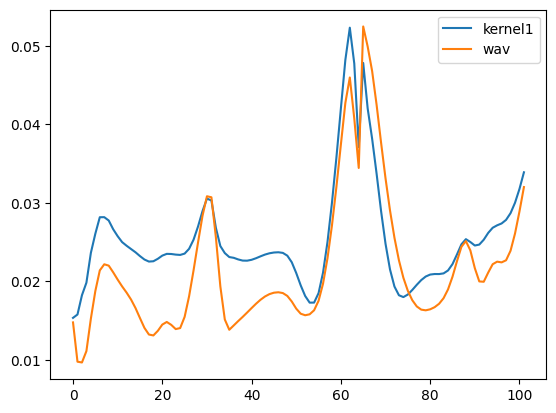

In [10]:
i = slice(0, 160)
plt.plot(temporal_RMSE(out_kernel1, sentinel_data[i_image0:])[i], label='kernel1')
# plt.plot(temporal_RMSE(out_kernel3, sentinel_data[i_image0:])[i], label='kernel3')
# plt.plot(temporal_RMSE(out_fou16, sentinel_data[i_image0:])[i], label='fou16')
# plt.plot(temporal_RMSE(out_fou32, sentinel_data[i_image0:])[i], label='fou32')
plt.plot(temporal_RMSE(out_wav, sentinel_data[i_image0:])[i], label='wav')
plt.legend()

In [11]:
def spatial_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2, dim=(0, 1))).detach().cpu().numpy()
    return RMSE

Text(0.5, 1.0, 'Difference in spatial RMSE between kernel1 and wavelet')

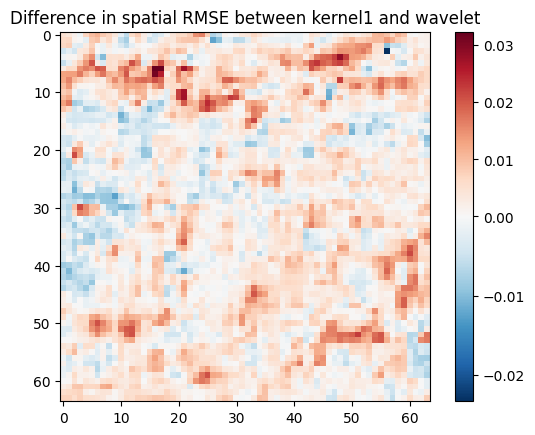

In [12]:
plt.imshow(spatial_RMSE(out_kernel1, sentinel_data[i_image0:]) - 
           spatial_RMSE(out_wav, sentinel_data[i_image0:]), cmap = 'RdBu_r', norm=norm)
plt.colorbar()
plt.title('Difference in spatial RMSE between kernel1 and wavelet')

Text(0.5, 1.0, 'Difference in spatial RMSE between fourier32 and wavelet')

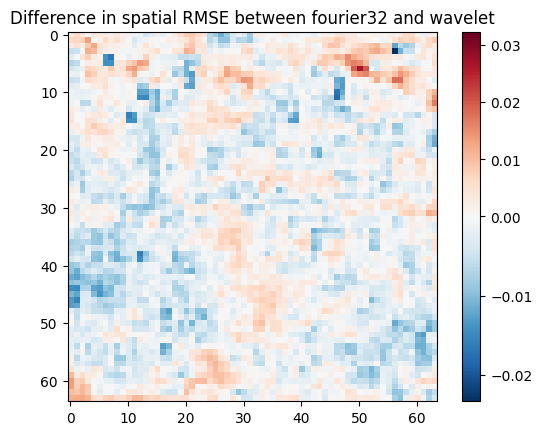

In [13]:
plt.imshow(spatial_RMSE(out_fou32, sentinel_data[i_image0:]) - 
           spatial_RMSE(out_wav, sentinel_data[i_image0:]), cmap = 'RdBu_r', norm=norm)
plt.colorbar()
plt.title('Difference in spatial RMSE between fourier32 and wavelet')

Text(0.5, 1.0, 'Difference in spatial RMSE between fourier32 and koopman')

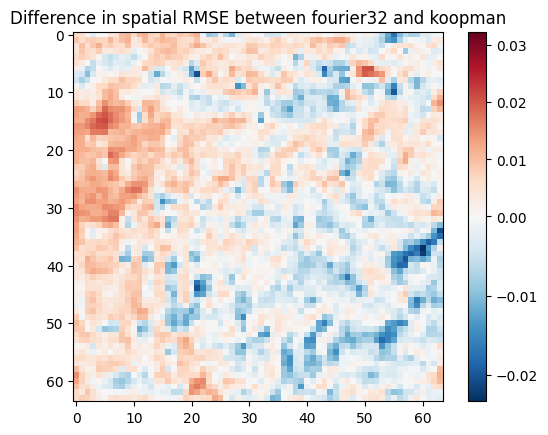

In [14]:
plt.imshow(spatial_RMSE(out_fou32, sentinel_data[i_image0:]) - 
           spatial_RMSE(out_koop, sentinel_data[i_image0:]), cmap = 'RdBu_r', norm=norm)
plt.colorbar()
plt.title('Difference in spatial RMSE between fourier32 and koopman')

Text(0.5, 1.0, 'Difference in spatial RMSE between fourier32 and koopman')

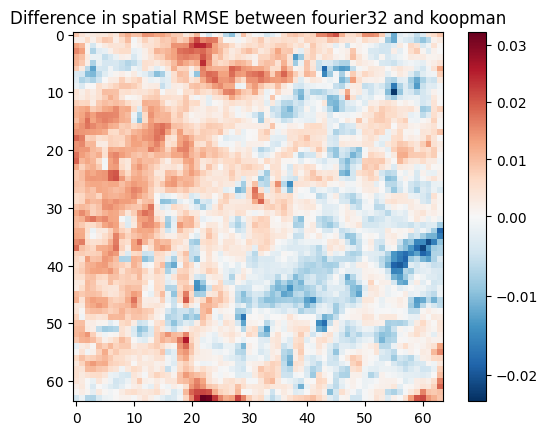

In [15]:
data = (spatial_RMSE(out_kernel3, sentinel_data[i_image0:]) - 
           spatial_RMSE(out_koop, sentinel_data[i_image0:]))


plt.imshow(data, cmap = 'RdBu_r' ,norm=norm)
plt.colorbar()
plt.title('Difference in spatial RMSE between fourier32 and koopman')

Text(0.5, 1.0, 'Difference in spatial RMSE between kernel1 and kernel3')

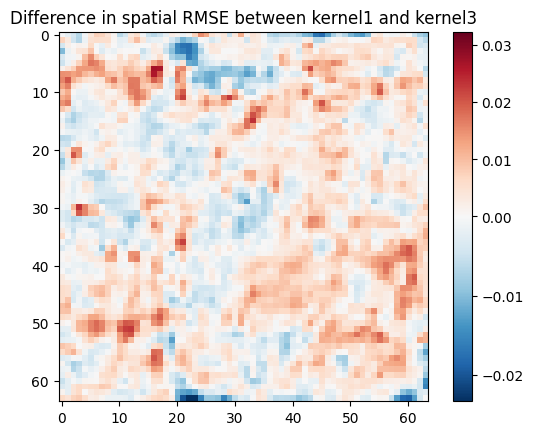

In [18]:
plt.imshow(spatial_RMSE(out_kernel1, sentinel_data[i_image0:]) - 
           spatial_RMSE(out_kernel3, sentinel_data[i_image0:]), cmap = 'RdBu_r', norm=norm)
plt.colorbar()
plt.title('Difference in spatial RMSE between kernel1 and kernel3')

In [16]:
def total_RMSE(out, data):
    RMSE = torch.sqrt(torch.mean((out - data)**2)).detach().cpu().numpy()
    return RMSE

In [17]:
#make a table with the RMSE for each model
RMSE_dict = {}
RMSE_dict['kernel 1'] = total_RMSE(out_kernel1, sentinel_data[i_image0:])
RMSE_dict['kernel 3'] = total_RMSE(out_kernel3, sentinel_data[i_image0:])
RMSE_dict['fourier 16'] = total_RMSE(out_fou16, sentinel_data[i_image0:])
RMSE_dict['fourier 32'] = total_RMSE(out_fou32, sentinel_data[i_image0:])
RMSE_dict['wavelet'] = total_RMSE(out_wav, sentinel_data[i_image0:])
RMSE_dict['koopman'] = total_RMSE(out_koop, sentinel_data[i_image0:])


RMSEstd_dict = {}
RMSEstd_dict['kernel 1'] = np.var(temporal_RMSE(out_kernel1, sentinel_data[i_image0:]))
RMSEstd_dict['kernel 3'] = np.var(temporal_RMSE(out_kernel3, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 16'] = np.var(temporal_RMSE(out_fou16, sentinel_data[i_image0:]))
RMSEstd_dict['fourier 32'] = np.var(temporal_RMSE(out_fou32, sentinel_data[i_image0:]))
RMSEstd_dict['wavelet'] = np.var(temporal_RMSE(out_wav, sentinel_data[i_image0:]))
RMSEstd_dict['koopman'] = np.var(temporal_RMSE(out_koop, sentinel_data[i_image0:]))

print('Model name  :  RMSE     +-  Variance')
print('-----------------------------------')
for key, value in RMSE_dict.items():
    num_spaces = 10 - len(key)
    print(key +" "*num_spaces, ' : ', "{:.5f}".format(value), ' +- ', "{:.7f}".format(RMSEstd_dict[key]))

Model name  :  RMSE     +-  Variance
-----------------------------------
kernel 1    :  0.02635  +-  0.0000464
kernel 3    :  0.02400  +-  0.0000577
fourier 16  :  0.04965  +-  0.0004262
fourier 32  :  0.02235  +-  0.0000593
wavelet     :  0.02340  +-  0.0000749
koopman     :  0.02093  +-  0.0000771
